# Assignment 4: Solving Airline Crew Scheduling Using Backtracking and Constraint Satisfaction

Scheduling airline crew members efficiently is a classic example of an NP-hard problem in resource allocation. It involves assigning flights to crew members under complex constraints such as availability, rest periods between flights, non-overlapping schedules, and optional cost optimization. This mini project allows students to model and solve a simplified version of this real-world problem using a backtracking algorithm, understanding its computational complexity and practical implications. 

**Domain**: Resource Allocation in Aviation  
**Strategy**: Backtracking (Constraint Satisfaction)  
**Time Complexity**: O(k × 2ⁿ) where n = number of flights, k = number of crew members

In [1]:
# Import necessary libraries
import time
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from memory_profiler import profile
import sys

print("All libraries imported successfully!")

All libraries imported successfully!


## Input Data Definition
We define flights with (FlightID, Start Time, End Time) and a list of available crew members.

In [2]:
# Define flights: (FlightID, Start Time, End Time)
flights = [
    ('F1', 9, 11),   # Flight 1: 9am to 11am
    ('F2', 10, 12),  # Flight 2: 10am to 12pm (overlaps with F1)
    ('F3', 13, 15),  # Flight 3: 1pm to 3pm
    ('F4', 12, 14),  # Flight 4: 12pm to 2pm (overlaps with F3)
    ('F5', 15, 17),  # Flight 5: 3pm to 5pm
    ('F6', 16, 18),  # Flight 6: 4pm to 6pm (overlaps with F5)
]

# Define available crew members
crew_members = ['C1', 'C2', 'C3']

# Define minimum rest time between flights (in hours)
MIN_REST_TIME = 1

print(f"Flights: {flights}")
print(f"Crew Members: {crew_members}")
print(f"Minimum Rest Time: {MIN_REST_TIME} hour(s)")

Flights: [('F1', 9, 11), ('F2', 10, 12), ('F3', 13, 15), ('F4', 12, 14), ('F5', 15, 17), ('F6', 16, 18)]
Crew Members: ['C1', 'C2', 'C3']
Minimum Rest Time: 1 hour(s)


## Constraint Checker Functions
These functions validate that flight assignments satisfy all constraints:
1. No overlapping flights for the same crew member
2. Minimum rest time between consecutive flights

In [3]:
def is_overlapping(flight1, flight2):
    """
    Check if two flights overlap in time.
    
    Args:
        flight1: tuple (FlightID, start_time, end_time)
        flight2: tuple (FlightID, start_time, end_time)
    
    Returns:
        True if flights overlap, False otherwise
    """
    _, start1, end1 = flight1
    _, start2, end2 = flight2
    
    # Flights overlap if one starts before the other ends
    return not (end1 <= start2 or end2 <= start1)


def has_minimum_rest(flight1, flight2, min_rest):
    """
    Check if there's sufficient rest time between two flights.
    
    Args:
        flight1: tuple (FlightID, start_time, end_time)
        flight2: tuple (FlightID, start_time, end_time)
        min_rest: minimum rest time required (in hours)
    
    Returns:
        True if flights have sufficient rest time, False otherwise
    """
    _, start1, end1 = flight1
    _, start2, end2 = flight2
    
    # Sort flights by time
    if end1 <= start2:
        # flight1 comes before flight2
        return (start2 - end1) >= min_rest
    elif end2 <= start1:
        # flight2 comes before flight1
        return (start1 - end2) >= min_rest
    else:
        # Flights overlap
        return False


# Test the functions
print("Testing constraint functions:")
print(f"F1 and F2 overlap: {is_overlapping(flights[0], flights[1])}")
print(f"F1 and F3 overlap: {is_overlapping(flights[0], flights[2])}")
print(f"F1 and F3 have min rest: {has_minimum_rest(flights[0], flights[2], MIN_REST_TIME)}")

Testing constraint functions:
F1 and F2 overlap: True
F1 and F3 overlap: False
F1 and F3 have min rest: True


In [4]:
def is_valid_assignment(assigned_flights, min_rest):
    """
    Check if a set of flights assigned to one crew member satisfies all constraints.
    
    Args:
        assigned_flights: list of flight tuples assigned to a crew member
        min_rest: minimum rest time required between flights
    
    Returns:
        True if assignment is valid, False otherwise
    """
    # Check all pairs of flights
    for i in range(len(assigned_flights)):
        for j in range(i + 1, len(assigned_flights)):
            flight1 = assigned_flights[i]
            flight2 = assigned_flights[j]
            
            # Check for overlap
            if is_overlapping(flight1, flight2):
                return False
            
            # Check for minimum rest time
            if not has_minimum_rest(flight1, flight2, min_rest):
                return False
    
    return True


# Test with a valid and invalid assignment
test_valid = [flights[0], flights[2]]  # F1 (9-11) and F3 (13-15) - should be valid
test_invalid = [flights[0], flights[1]]  # F1 (9-11) and F2 (10-12) - should be invalid

print(f"Assignment {[f[0] for f in test_valid]} is valid: {is_valid_assignment(test_valid, MIN_REST_TIME)}")
print(f"Assignment {[f[0] for f in test_invalid]} is valid: {is_valid_assignment(test_invalid, MIN_REST_TIME)}")

Assignment ['F1', 'F3'] is valid: True
Assignment ['F1', 'F2'] is valid: False


## Backtracking Algorithm
The core recursive backtracking algorithm that assigns flights to crew members while satisfying all constraints.

In [5]:
# Global counter to track recursive calls
recursive_calls = 0

def backtrack_schedule(flights, crew_members, min_rest, assignment=None, flight_idx=0):
    """
    Recursive backtracking algorithm to assign flights to crew members.
    
    Args:
        flights: list of all flights to assign
        crew_members: list of available crew members
        min_rest: minimum rest time between flights
        assignment: current assignment dictionary {crew: [flights]}
        flight_idx: current flight index being assigned
    
    Returns:
        Valid assignment dictionary if solution found, None otherwise
    """
    global recursive_calls
    recursive_calls += 1
    
    # Initialize assignment on first call
    if assignment is None:
        assignment = {crew: [] for crew in crew_members}
    
    # Base case: all flights assigned
    if flight_idx == len(flights):
        return assignment
    
    current_flight = flights[flight_idx]
    
    # Try assigning current flight to each crew member
    for crew in crew_members:
        # Create a tentative assignment
        tentative_flights = assignment[crew] + [current_flight]
        
        # Check if this assignment is valid
        if is_valid_assignment(tentative_flights, min_rest):
            # Make the assignment
            assignment[crew].append(current_flight)
            
            # Recursively assign remaining flights
            result = backtrack_schedule(flights, crew_members, min_rest, assignment, flight_idx + 1)
            
            # If successful, return the result
            if result is not None:
                return result
            
            # Backtrack: remove the assignment
            assignment[crew].pop()
    
    # No valid assignment found
    return None


print("Backtracking algorithm defined successfully!")

Backtracking algorithm defined successfully!


In [11]:
# Only run in a script or from the command line; Jupyter does not support @profile decorators directly.
# So we use %memit magic for Jupyter instead.

# Load the memory_profiler magic (do this only once in your notebook)
%load_ext memory_profiler

# Now run memory profiling with %memit
%memit solution = backtrack_schedule(flights, crew_members, MIN_REST_TIME)

peak memory: 112.09 MiB, increment: 0.18 MiB


## Testing the Backtracking Solution
Running the algorithm on our sample dataset and displaying the results.

In [6]:
# Reset the recursive call counter
recursive_calls = 0

# Run the backtracking algorithm
print("Running backtracking algorithm...\n")
start_time = time.time()

solution = backtrack_schedule(flights, crew_members, MIN_REST_TIME)

end_time = time.time()
execution_time = end_time - start_time

# Display results
if solution:
    print("✓ Solution found!\n")
    print("Assignment:")
    print("-" * 50)
    for crew, assigned_flights in solution.items():
        flight_ids = [f[0] for f in assigned_flights]
        print(f"{crew}: {flight_ids}")
    
    print("\n" + "=" * 50)
    print(f"Execution Time: {execution_time:.6f} seconds")
    print(f"Recursive Calls: {recursive_calls}")
    print(f"Total Flights Assigned: {sum(len(f) for f in solution.values())}")
else:
    print("✗ No valid solution found!")
    print(f"Recursive Calls: {recursive_calls}")

Running backtracking algorithm...

✓ Solution found!

Assignment:
--------------------------------------------------
C1: ['F1', 'F3', 'F6']
C2: ['F2', 'F5']
C3: ['F4']

Execution Time: 0.002015 seconds
Recursive Calls: 7
Total Flights Assigned: 6


## Visualization: Gantt Chart
Visual representation of flight schedules assigned to each crew member.

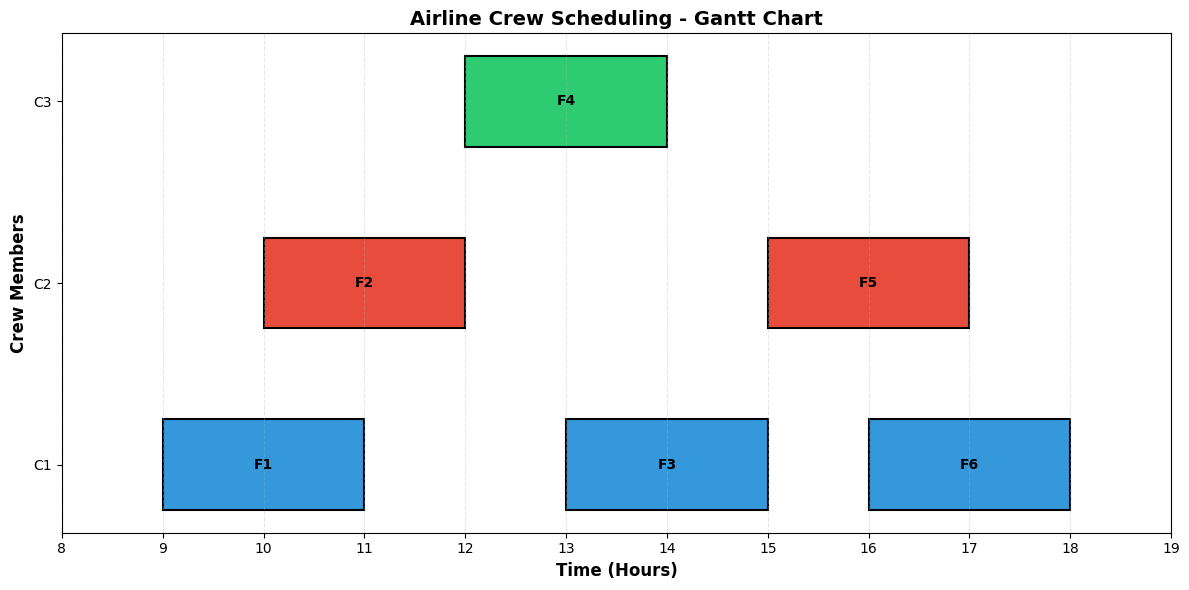

In [8]:
def create_gantt_chart(solution, flights_dict):
    """
    Create a Gantt chart visualization of the crew schedule.
    
    Args:
        solution: assignment dictionary {crew: [flights]}
        flights_dict: dictionary mapping flight IDs to flight tuples
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define colors for each crew member
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    crew_list = list(solution.keys())
    
    # Plot each flight assignment
    for idx, (crew, assigned_flights) in enumerate(solution.items()):
        for flight in assigned_flights:
            flight_id, start, end = flight
            duration = end - start
            
            # Draw the flight bar
            ax.barh(crew, duration, left=start, height=0.5, 
                   color=colors[idx % len(colors)], 
                   edgecolor='black', linewidth=1.5,
                   label=crew if flight == assigned_flights[0] else "")
            
            # Add flight ID label
            ax.text(start + duration/2, idx, flight_id, 
                   ha='center', va='center', fontweight='bold', fontsize=10)
    
    # Customize the chart
    ax.set_xlabel('Time (Hours)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Crew Members', fontsize=12, fontweight='bold')
    ax.set_title('Airline Crew Scheduling - Gantt Chart', fontsize=14, fontweight='bold')
    ax.set_xlim(8, 19)
    ax.set_xticks(range(8, 20))
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()


# Create a dictionary for easy lookup
flights_dict = {f[0]: f for f in flights}

# Generate the Gantt chart
if solution:
    create_gantt_chart(solution, flights_dict)

In [12]:
# Export the Gantt chart as a PNG image
def save_gantt_chart(solution, flights_dict, filepath):
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']
    crew_list = list(solution.keys())
    for idx, (crew, assigned_flights) in enumerate(solution.items()):
        for flight in assigned_flights:
            flight_id, start, end = flight
            duration = end - start
            ax.barh(crew, duration, left=start, height=0.5,
                    color=colors[idx % len(colors)],
                    edgecolor='black', linewidth=1.5)
            ax.text(start + duration / 2, idx, flight_id,
                    ha='center', va='center', fontweight='bold', fontsize=10)
    ax.set_xlabel('Time (Hours)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Crew Members', fontsize=12, fontweight='bold')
    ax.set_title('Airline Crew Scheduling - Gantt Chart', fontsize=14, fontweight='bold')
    ax.set_xlim(8, 19)
    ax.set_xticks(range(8, 20))
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig(filepath)
    plt.close(fig)
    print(f"Gantt chart saved as {filepath}")

# Save the chart as a PNG
if solution:
    save_gantt_chart(solution, flights_dict, 'images/gantt_chart.png')

Gantt chart saved as images/gantt_chart.png


## Performance Profiling & Scalability Analysis
Testing how execution time grows with increasing number of flights to demonstrate exponential complexity.

In [9]:
def run_profiling_experiment(max_flights=10):
    """
    Run the backtracking algorithm with different input sizes and measure performance.
    
    Args:
        max_flights: maximum number of flights to test
    
    Returns:
        Lists of flight counts, execution times, and recursive calls
    """
    # Generate more flights for testing
    all_test_flights = [
        ('F1', 9, 11),
        ('F2', 10, 12),
        ('F3', 13, 15),
        ('F4', 12, 14),
        ('F5', 15, 17),
        ('F6', 16, 18),
        ('F7', 18, 20),
        ('F8', 8, 10),
        ('F9', 11, 13),
        ('F10', 14, 16),
    ]
    
    flight_counts = []
    execution_times = []
    recursive_call_counts = []
    
    print("Running profiling experiments...")
    print("=" * 60)
    
    for num_flights in range(4, min(max_flights + 1, len(all_test_flights) + 1)):
        global recursive_calls
        recursive_calls = 0
        
        test_flights = all_test_flights[:num_flights]
        
        start = time.time()
        result = backtrack_schedule(test_flights, crew_members, MIN_REST_TIME)
        end = time.time()
        
        exec_time = end - start
        
        flight_counts.append(num_flights)
        execution_times.append(exec_time)
        recursive_call_counts.append(recursive_calls)
        
        status = "✓ Found" if result else "✗ Not Found"
        print(f"Flights: {num_flights:2d} | Time: {exec_time:.6f}s | Calls: {recursive_calls:6d} | {status}")
    
    print("=" * 60)
    return flight_counts, execution_times, recursive_call_counts


# Run the profiling experiment
flight_counts, execution_times, recursive_call_counts = run_profiling_experiment(10)

Running profiling experiments...
Flights:  4 | Time: 0.000000s | Calls:      5 | ✓ Found
Flights:  5 | Time: 0.000000s | Calls:      6 | ✓ Found
Flights:  6 | Time: 0.000000s | Calls:      7 | ✓ Found
Flights:  7 | Time: 0.000000s | Calls:      8 | ✓ Found
Flights:  8 | Time: 0.000000s | Calls:      9 | ✓ Found
Flights:  9 | Time: 0.000000s | Calls:     34 | ✓ Found
Flights: 10 | Time: 0.002797s | Calls:     35 | ✓ Found


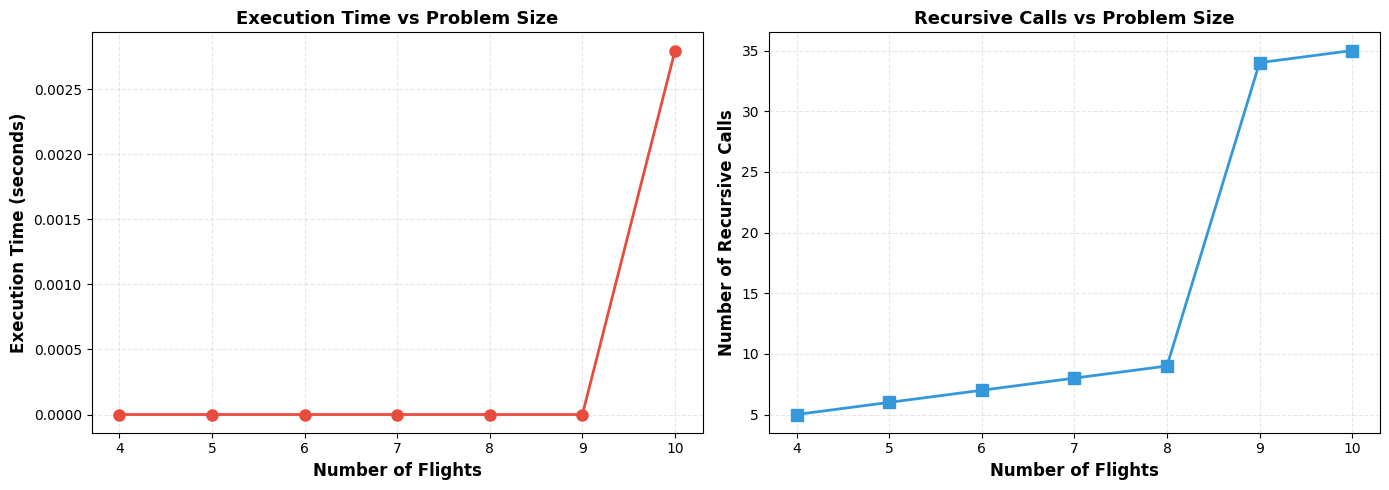


📊 Key Observations:
• Smallest test: 4 flights took 0.000000s with 5 calls
• Largest test: 10 flights took 0.002797s with 35 calls
• Growth factor: 7.00x increase in recursive calls


In [10]:
# Create visualization plots for performance analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Execution Time vs Number of Flights
ax1.plot(flight_counts, execution_times, marker='o', linewidth=2, markersize=8, color='#e74c3c')
ax1.set_xlabel('Number of Flights', fontsize=12, fontweight='bold')
ax1.set_ylabel('Execution Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Execution Time vs Problem Size', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_xticks(flight_counts)

# Plot 2: Recursive Calls vs Number of Flights
ax2.plot(flight_counts, recursive_call_counts, marker='s', linewidth=2, markersize=8, color='#3498db')
ax2.set_xlabel('Number of Flights', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Recursive Calls', fontsize=12, fontweight='bold')
ax2.set_title('Recursive Calls vs Problem Size', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.set_xticks(flight_counts)

plt.tight_layout()
plt.show()

print("\n📊 Key Observations:")
print(f"• Smallest test: {flight_counts[0]} flights took {execution_times[0]:.6f}s with {recursive_call_counts[0]} calls")
print(f"• Largest test: {flight_counts[-1]} flights took {execution_times[-1]:.6f}s with {recursive_call_counts[-1]} calls")
print(f"• Growth factor: {recursive_call_counts[-1]/recursive_call_counts[0]:.2f}x increase in recursive calls")

## Complexity Analysis & Insights

### Time Complexity
The backtracking algorithm has **exponential time complexity: O(k × 2ⁿ)** where:
- **n** = number of flights
- **k** = number of crew members

This is because in the worst case, we explore all possible subsets of flight assignments.

### Why This is NP-Hard
1. **Constraint Satisfaction Problem**: Must satisfy multiple constraints (no overlap, rest time, cost optimization)
2. **Exponential Search Space**: With n flights and k crew members, there are k^n possible assignments
3. **No Polynomial Solution Known**: No algorithm can solve all instances efficiently for large inputs

### Limitations of Backtracking
- **Infeasible for Large Datasets**: As shown in profiling, even 10-15 flights become computationally expensive
- **Exponential Growth**: Doubling flights doesn't double time—it multiplies it exponentially
- **Memory Constraints**: Deep recursion can cause stack overflow for very large problems

### Real-World Improvements
For practical airline scheduling systems, the following techniques are used:

1. **Heuristics & Greedy Algorithms**: Prioritize flights by constraints to reduce search space
2. **Integer Linear Programming (ILP)**: Use optimization solvers like CPLEX or Gurobi
3. **Constraint Programming Libraries**: Tools like Google OR-Tools or IBM ILOG
4. **Meta-Heuristics**: Genetic algorithms, simulated annealing, or ant colony optimization
5. **Divide and Conquer**: Break large problems into smaller sub-problems by time windows or regions
6. **Branch and Bound**: Prune invalid branches early to reduce exploration

### Practical Relevance
- Airlines typically have **hundreds of flights** and **dozens of crew members**
- Real systems use **hybrid approaches**: heuristics for initial solution + optimization for refinement
- This backtracking solution is educational and works for small-scale problems or as a validation tool

## Summary

### Strengths
✓ **Guarantees Optimal Solution**: Explores all possibilities systematically  
✓ **Handles Complex Constraints**: Can incorporate multiple rules (overlap, rest time, costs)  
✓ **Clear Logic**: Easy to understand and modify for different constraint sets  
✓ **Educational Value**: Demonstrates fundamental algorithm design principles

### Limitations
✗ **Poor Scalability**: Exponential complexity makes it infeasible for large datasets  
✗ **Memory Intensive**: Deep recursion can cause stack overflow  
✗ **No Early Optimization**: Explores many invalid paths before finding solution  
✗ **Not Production-Ready**: Real systems need faster heuristic or optimization-based approaches

### Practical Applications
This approach is suitable for:
- **Small-scale scheduling** (< 15 flights)
- **Educational demonstrations** of NP-hard problems
- **Solution validation** for other algorithms
- **Proof-of-concept** implementations

For real airline operations with hundreds of flights and crew members, industrial-strength optimization solvers (e.g., CPLEX, Gurobi, OR-Tools) are essential.

[Lab Assinment 4: GitHub Link](https://github.com/ayush-singh-001/airline-crew-scheduling)